# Introduction

Self-driving cars rely on cameras and sensors to percieve the surrounding environment. It an be assumed that the cameras act as the "eye" of the autonomous vehicle, but images and videos taken by the camers must to be mathematically processed in order to be understandable for the car computers.


The objective of this project is to ind the lane lines on the road using camera images. 
The proposed pipeline includes color and region masking, Canny edge detection and Hough transformation.
This pipeline is first implemented and tested on some camera images and then validated on a video file.

### Pre-requisite:

As the first step, all the required libraris are imported.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In order to import images into the jupyter notebook, matplotlib library is used with the image's file name and location. In addition, `<type()>` and `<.shape>` can provide useful information about the image.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


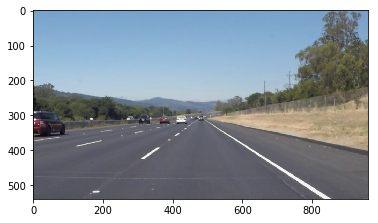

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

img=np.copy(image)

The proposed pipeline includes The following steps:

#### 1. Convert to Gray-Scale

In the first step the image is converted into grayscale:

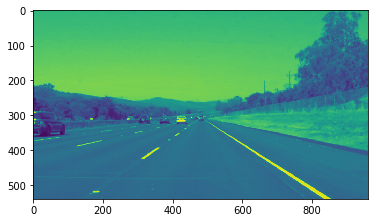

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray=grayscale(img)
plt.imshow(gray)

#### 2. Filtering Gaussian Noise

We are performing gaussian smoothin to reduce the noise. Any odd number can be chosen for the `<kernel_size>` variable of this function.

In [4]:
def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

kernel_size=7
gray=gaussian_noise(img, kernel_size)

#### 3. Canny Ege Detection
Canny-edge detection is implemented on the images to find the edge of the lane lines. This funtion finds the gradient pixels whose values are between the `<high_threshold>` and `<low_threshold>`.

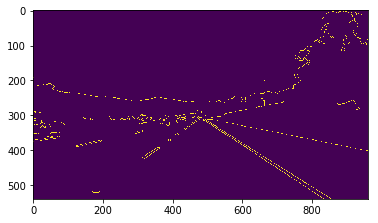

In [5]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

low_threshold=50
high_threshold=150
edges=canny(gray, low_threshold, high_threshold)
plt.imshow(edges)

#### 4. Region of Interest

For simplicity, the processing is focused on the area of the image with the lane lines. Thus, a quadrilateral is introduced with vertices around the lane line area to separate that region.

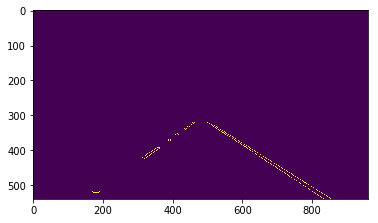

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)    
masked = region_of_interest(edges, vertices)
plt.imshow(masked)

#### 5. Hough Transform

After deteting the lane line edges in the image, Hough transform is used to find the lanes. The finction `<cv2.HoughLinesP>` determines whether each pizel is part of a line or not. This finction has the following parameters:
`<rho, theta, threshold, minLineLength, maxLineGap>` which can be tuned to for the desired results.

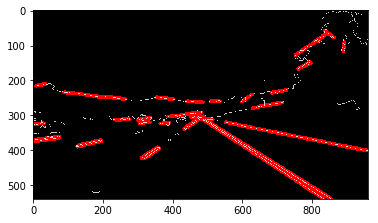

In [7]:
rho = 2            #distance resolution in pixels of the Hough grid
theta = np.pi/180  #angular resolution in radians of the Hough grid
threshold = 20     #minimum number of votes (intersections in Hough grid cell)
min_line_len = 25  #minimum number of pixels making up a line
max_line_gap = 10  #maximum gap in pixels between connectable line segments


lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)


line_image = np.copy(image)*0 #creating a blank to draw lines on


# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

#### 6. Drawing Lines

Now, all the mini-line snippets obtained from the hough transform should be aggregated into two continous lines for right and left lanes. 
The `<draw_line>` funtion is developed which cosists of both interpolation and extrapolation to combine all the mini lines.

In [8]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    top = 320
    bottom = 550
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    for line in lines:
        #print(line)
        # Feel this is the brute force method, but I'm time constrained. I will research ideal numpy methods later.
        for x1,y1,x2,y2 in line:
            # Draw line segments in blue for error checking.
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], 6)
            
            slope = get_slope(x1,y1,x2,y2)
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue        
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue        
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)
                
    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = get_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = top
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        # Don't error when a line cannot be drawn
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = get_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = top
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        # Don't error when a line cannot be drawn
        pass
    
def get_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))

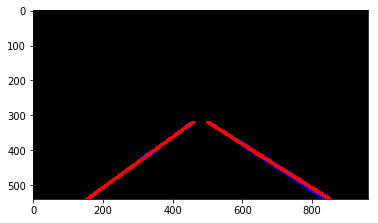

In [9]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    # Make a RGB shape of the correct dimensions
    shape = (img.shape[0], img.shape[1], 3)
    line_img = np.zeros(shape, dtype=np.uint8)

    draw_lines(line_img, lines)
    return line_img


rho = 2            #distance resolution in pixels of the Hough grid
theta = np.pi/180  #angular resolution in radians of the Hough grid
threshold = 20     #minimum number of votes (intersections in Hough grid cell)
min_line_len = 25  #minimum number of pixels making up a line
max_line_gap = 10  #maximum gap in pixels between connectable line segments
line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)

plt.imshow(line_image)

#### 7. Weighted Image

In order to the detected lane lines on the actual test image, a weighted sum of the two images is generated:


In [10]:
def weighted_img(img, initial_img, α=.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Now that all the components of the pipeline are working well, they are all combined into one main funtion.

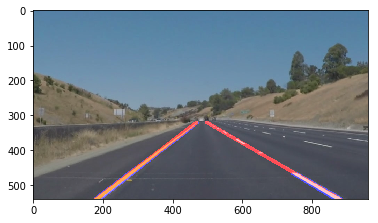

In [11]:
import os 
%matplotlib inline

# Used here on images and below on videos.
def process_image(image):
    # you should return the final output (image with lines are drawn on lanes)
    gray = grayscale(image)
    gaus = gaussian_noise(gray, 7)
    edges = canny(gaus, 50,150)    
    imshape = image.shape
    
    vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)    
    masked = region_of_interest(edges, vertices)
    
    rho = 2            #distance resolution in pixels of the Hough grid
    theta = np.pi/180  #angular resolution in radians of the Hough grid
    threshold = 20     #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 25  #minimum number of pixels making up a line
    max_line_gap = 10  #maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    
    result = weighted_img(line_image, image)
    return result


images = os.listdir("test_images/")
for img_file in images:
    #print(img_file)
    # Skip all files starting with line.
    if img_file[0:4] == 'line':
        continue
    
    image = mpimg.imread('test_images/' + img_file)   
    
    weighted = process_image(image)

    plt.imshow(weighted)
    #break
    mpimg.imsave('test_images/lines-' + img_file, weighted)

### Video Processing

Now that the pipeline is working on the test images, we cam implement it on the test videos. First, the packages required to read and process video files are imported: 

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
white_output = 'test_videos_out/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_out/white.mp4
[MoviePy] Writing video test_videos_out/white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:08<00:00, 24.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_out/white.mp4 

Wall time: 9.89 s


In [14]:
white_output = 'test_videos_out/yellow.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_out/yellow.mp4
[MoviePy] Writing video test_videos_out/yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:32<00:00, 21.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_out/yellow.mp4 

Wall time: 34.1 s


In [15]:
white_output = 'test_videos_out/challenge.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_out/challenge.mp4
[MoviePy] Writing video test_videos_out/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:28<00:00,  6.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_out/challenge.mp4 

Wall time: 32.9 s


### Project Shortcomnings

This pipeline is mostly depending on the color contrasts for detecting the lane lines. As a results, its performance will seriously degrade in low light conditions which makes colors hard to detect, such as night time or cloudy weather.
In addition, the pipeline is designed only for straight roads and is not capable of adapting to curvature which is a big disadvantage.
Moreover, the pipeline will not perform in conditions with no lane markings or degraded markings

### Possible Improvements

One possible improvement is to make the car adaptable with the curvature.
Another suggestion is to include road data into the lane line detection pipeline to increase the confidence of detection and also help predict the lane markings if they are erased or hard to see because of low light.